# Setup

In [38]:
%matplotlib notebook
LOG_PLOT = False
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *

## ECDC Data

In [39]:


def plot_selection(selection, roll_days=7, log=False):
    

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f


def select_country(geoId):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)
    return selection

def plot_country(geoId, **kwargs):
    return plot_selection(select_country(geoId), **kwargs)
    
df = ecdc()


## Austria - from Gesundheitsminesterium

In [40]:

def plot_Austria(roll_days=7, log=False):
    df = at()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f


## DF Subsets

In [41]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [42]:
overview(SELECTION)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6394068          575498       82214  81484  97894   
United_States_of_America  7277814          299397       42771  44771  78427   
United_Kingdom             460178           43815        6259   6914   7143   
Netherlands                123966           20932        2990   3253   3293   
Germany                    294395           14172        2025   2673   6294   
Italy                      317409           13086        1869   2548   6557   
Austria                     46317            5071         724    564   1146   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      99773            7483        1069   1095  2003   
United_States_of_America  207808            4998         714    880  4928   
United_Kingdom             42202             300          43     59  1224   
Netherlands                 6410             107          15     13   234   
Germany                     9508              65           9      8   315   
Italy                      35918             137          20     24   971   
Austria                      802              19           3      3    31   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-10-02  
United_States_of_America 2019-12-31 2020-10-02  
United_Kingdom           2019-12-31 2020-10-02  
Netherlands              2019-12-31 2020-10-02  
Germany                  2019-12-31 2020-10-02  
Italy                    2019-12-31 2020-10-02  
Austria                  2019-12-31 2020-10-02

## Most cases in the last 7 days

### Europe

In [19]:
overview(EU).head(10)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    577505           80268       11467  13970  16096   
Spain                     778607           74398       10628   9419  31785   
Russia                   1185231           56395        8056   8945  11656   
United_Kingdom            460178           43815        6259   6914   7143   
Netherlands               123966           20932        2990   3253   3293   
Ukraine                   208959           20853        2979      0   5863   
Czechia                    74255           15881        2269   5336   5336   
Germany                   294395           14172        2025   2673   6294   
Italy                     317409           13086        1869   2548   6557   
Romania                   129658           11604        1658   2086   2158   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
France                   32019             508          73     63  2004   
Spain                    31973             855         122    182  1179   
Russia                   20891             943         135    169   312   
United_Kingdom           42202             300          43     59  1224   
Netherlands               6410             107          15     13   234   
Ukraine                   4193             436          62     64   129   
Czechia                    678             111          16     23    24   
Germany                   9508              65           9      8   315   
Italy                    35918             137          20     24   971   
Romania                   4862             271          39     37    60   

                           dateRep             
                               min        max  
countriesAndTerritories                        
France                  2019-12-31 2020-10-02  
Spain                   2019-12-31 2020-10-01  
Russia                  2019-12-31 2020-10-02  
United_Kingdom          2019-12-31 2020-10-02  
Netherlands             2019-12-31 2020-10-02  
Ukraine                 2020-03-04 2020-10-02  
Czechia                 2019-12-31 2020-10-02  
Germany                 2019-12-31 2020-10-02  
Italy                   2019-12-31 2020-10-02  
Romania                 2019-12-31 2020-10-02

### America

In [20]:
overview(AMERICA).head(5)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
United_States_of_America  7277814          299397       42771  44771  78427   
Brazil                    4847092          189390       27056  36157  69074   
Argentina                  764989           86723       12389  14001  17213   
Colombia                   835339           44516        6359   5660  13056   
Mexico                     748315           32858        4694   5099   9556   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
United_States_of_America  207808            4998         714    880  4928   
Brazil                    144680            4872         696    728  1595   
Argentina                  20288            5522         789   3351  3351   
Colombia                   26196            1272         182    198   400   
Mexico                     78078            2639         377    432  1091   

                            dateRep             
                                min        max  
countriesAndTerritories                         
United_States_of_America 2019-12-31 2020-10-02  
Brazil                   2019-12-31 2020-10-02  
Argentina                2020-03-04 2020-10-02  
Colombia                 2020-03-07 2020-10-02  
Mexico                   2019-12-31 2020-10-02

### World

In [21]:
overview(df).head(10)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     6394068          575498       82214  81484  97894   
United_States_of_America  7277814          299397       42771  44771  78427   
Brazil                    4847092          189390       27056  36157  69074   
Argentina                  764989           86723       12389  14001  17213   
France                     577505           80268       11467  13970  16096   
Spain                      778607           74398       10628   9419  31785   
Russia                    1185231           56395        8056   8945  11656   
Colombia                   835339           44516        6359   5660  13056   
United_Kingdom             460178           43815        6259   6914   7143   
Israel                     255771           41313        5902   7638  11827   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      99773            7483        1069   1095  2003   
United_States_of_America  207808            4998         714    880  4928   
Brazil                    144680            4872         696    728  1595   
Argentina                  20288            5522         789   3351  3351   
France                     32019             508          73     63  2004   
Spain                      31973             855         122    182  1179   
Russia                     20891             943         135    169   312   
Colombia                   26196            1272         182    198   400   
United_Kingdom             42202             300          43     59  1224   
Israel                      1622             244          35     51    71   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-10-02  
United_States_of_America 2019-12-31 2020-10-02  
Brazil                   2019-12-31 2020-10-02  
Argentina                2020-03-04 2020-10-02  
France                   2019-12-31 2020-10-02  
Spain                    2019-12-31 2020-10-01  
Russia                   2019-12-31 2020-10-02  
Colombia                 2020-03-07 2020-10-02  
United_Kingdom           2019-12-31 2020-10-02  
Israel                   2019-12-31 2020-10-02

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [23]:
overview(EU[EU.popData2019>1*10**6]).tail(10)

cases                                         deaths  \
                           sum last_7_days_sum rolling_avg latest  max    sum   
countriesAndTerritories                                                         
North_Macedonia          18138             938         134    161  403    743   
Albania                  13806             885         126    157  178    388   
Norway                   14027             752         107    113  425    274   
Finland                  10103             724         103    111  267    344   
Lithuania                 4784             714         102     91  138     92   
Azerbaijan               40309             623          89     80  590    593   
Serbia                   33662             499          71    111  467    750   
Estonia                   3450             374          53     79  134     65   
Kosovo                   15663             330          47     43  496    627   
Latvia                    1868             274          39     44   95     37   

                                                                  dateRep  \
                        last_7_days_sum rolling_avg latest max        min   
countriesAndTerritories                                                     
North_Macedonia                      31           4      4  16 2019-12-31   
Albania                              18           3      1   6 2020-03-09   
Norway                                4           1      0  13 2019-12-31   
Finland                               1           0      0  43 2019-12-31   
Lithuania                             3           0      0   6 2019-12-31   
Azerbaijan                           12           2      2  13 2019-12-31   
Serbia                                5           1      1  18 2020-03-07   
Estonia                               1           0      1   6 2019-12-31   
Kosovo                               11           2      2  40 2020-03-14   
Latvia                                1           0      0   4 2020-03-03   

                                    
                               max  
countriesAndTerritories             
North_Macedonia         2020-10-02  
Albania                 2020-10-02  
Norway                  2020-10-02  
Finland                 2020-10-02  
Lithuania               2020-10-02  
Azerbaijan              2020-10-02  
Serbia                  2020-10-02  
Estonia                 2020-10-02  
Kosovo                  2020-10-02  
Latvia                  2020-10-02

### America*

\*among countries with population of at least 10 million

In [24]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Guatemala                 92409            4476         639    663  4233   
Bolivia                  135716            3098         443    405  2687   
Dominican_Republic       112728            2606         372    519  2147   
Cuba                       5670             360          51     73    93   
Haiti                      8766             120          17      0   284   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Guatemala                 3261              91          13     15    74   
Bolivia                   8001             236          34     36  1610   
Dominican_Republic        2108              32           5      3    39   
Cuba                       122               4           1      0     6   
Haiti                      229               4           1      0    12   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Guatemala               2020-03-15 2020-10-02  
Bolivia                 2020-03-12 2020-10-02  
Dominican_Republic      2019-12-31 2020-10-02  
Cuba                    2020-03-12 2020-10-02  
Haiti                   2020-03-20 2020-10-02

### World*
\*among countries with population of at least 10 million

In [25]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                          \
                              sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                     
Taiwan                        517               8           1      3   31   
Yemen                        2038               5           1      3  116   
Niger                        1197               3           0      0   69   
Cambodia                      277               2           0      0   35   
United_Republic_of_Tanzania   509               0           0      0  174   

                            deaths                                         \
                               sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                     
Taiwan                           7               0           0      0   3   
Yemen                          588               1           0      0  52   
Niger                           69               0           0      0   5   
Cambodia                         0               0           0      0   0   
United_Republic_of_Tanzania     21               0           0      0   6   

                               dateRep             
                                   min        max  
countriesAndTerritories                            
Taiwan                      2019-12-31 2020-10-02  
Yemen                       2020-04-10 2020-10-02  
Niger                       2020-03-21 2020-10-02  
Cambodia                    2019-12-31 2020-10-02  
United_Republic_of_Tanzania 2020-03-17 2020-10-02

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

<IPython.core.display.Javascript object>


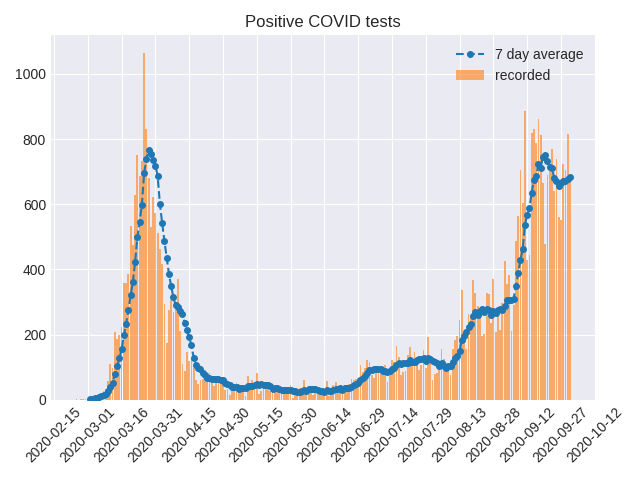

<IPython.core.display.Javascript object>


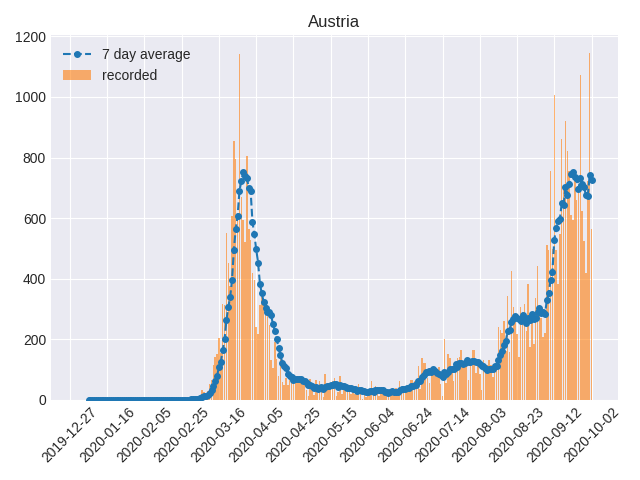

In [29]:
plot_Austria();
plot_country('AT', log=LOG_PLOT);

### Weekday bias

<IPython.core.display.Javascript object>


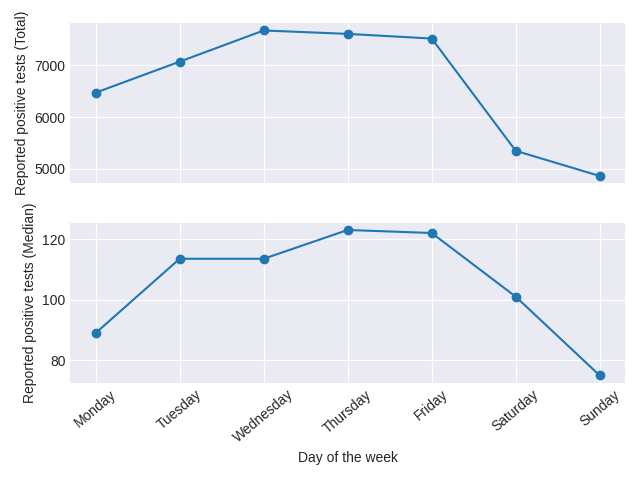

In [30]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


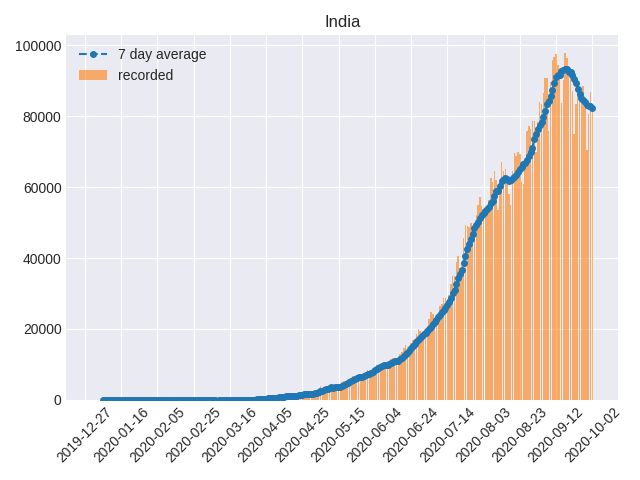

In [31]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


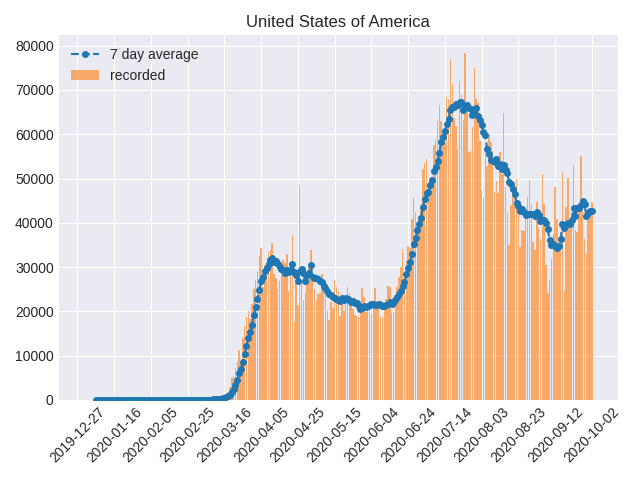

In [32]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


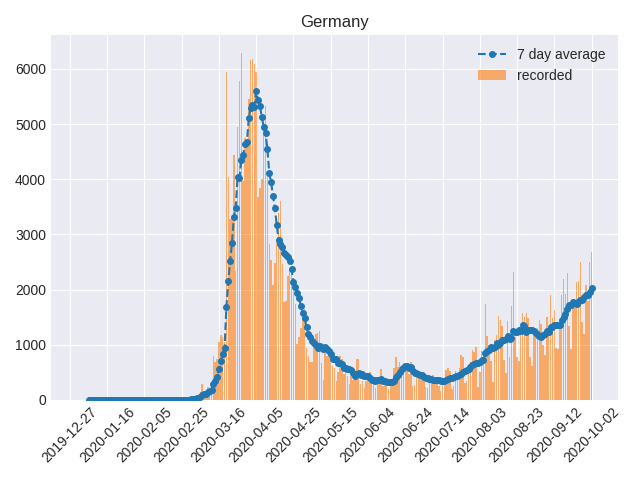

In [33]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


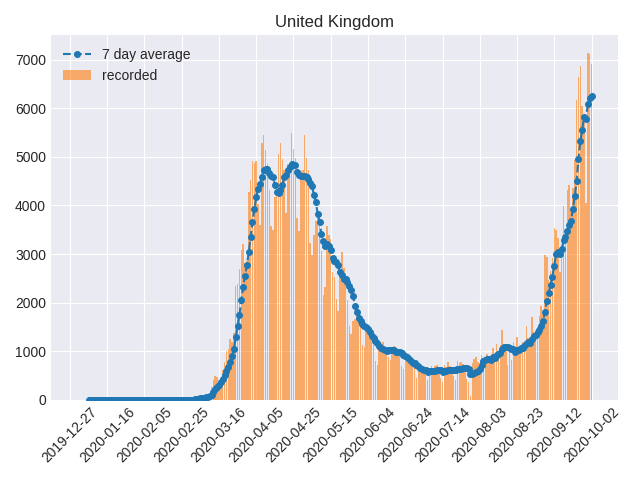

In [34]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


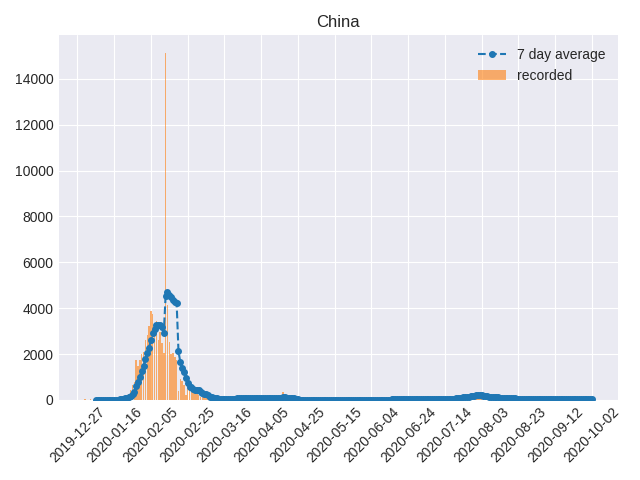

In [35]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [36]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular f04b2e0] Last run on 2020-10-02 11:51
 5 files changed, 9543 insertions(+), 11455 deletions(-)
 rewrite notebooks/.ipynb_checkpoints/Austria_ECDC Data Differences-checkpoint.ipynb (66%)
 rewrite notebooks/Austria_ECDC Data Differences.ipynb (65%)
 create mode 100644 notebooks/__pycache__/helper.cpython-37.pyc
 rewrite notebooks/explore_ecdc_data.ipynb (70%)
 create mode 100644 notebooks/helper.py
fatal: The current branch feature/angular has no upstream branch.
To push the current branch and set the remote as upstream, use

    git push --set-upstream origin feature/angular



In [37]:
! git push --set-upstream origin feature/angular


Enumerating objects: 87, done.
Counting objects: 100% (86/86), done.
Delta compression using up to 16 threads
Compressing objects: 100% (78/78), done.
Writing objects: 100% (81/81), 1.10 MiB | 13.40 MiB/s, done.
Total 81 (delta 22), reused 0 (delta 0)
remote: Resolving deltas: 100% (22/22), completed with 2 local objects.
remote: 
remote: Create a pull request for 'feature/angular' on GitHub by visiting:
remote:      https://github.com/gythaogg/covid19/pull/new/feature/angular
remote: 
To github.com:gythaogg/covid19.git
 * [new branch]      feature/angular -> feature/angular
Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
